<h1 align="center"><font color="0066FF" size=110>Ordinary Differential Equations II: Runge-Kutta and Advanced Methods</font></h1>


In [50]:
# Setup notebook
import numpy as np
# Uncomment next two lines for bigger fonts
import matplotlib
try:
    %matplotlib inline
except:
    # not in notebook
    pass
from IPython.html.widgets import interact
LECTURE = False
if LECTURE:
    size = 20
    matplotlib.rcParams['figure.figsize'] = (10, 6)
    matplotlib.rcParams['axes.labelsize'] = size
    matplotlib.rcParams['axes.titlesize'] = size
    matplotlib.rcParams['xtick.labelsize'] = size * 0.6
    matplotlib.rcParams['ytick.labelsize'] = size * 0.6
import matplotlib.pyplot as plt



# Learning Outcomes

-   Describe the rationale behind Runge-Kutta methods.
-   Implement a Runge-Kutta method such as 4th order Runge-Kutta (RK4) given the intermediate steps and weighting coefficients.
-   Solve a first order explicit initial value problem using RK4.
-   Discuss the trade-off between reducing the step size and using a Runge-Kutta method of higher order.

# Introduction

In the previous lecture we discussed Euler's method, which is based on approximating the solution as a polynomial of order 1 using Taylor's theorem. Indeed, given an explicit ODE $y' = F(t, y(t))$, we have

\begin{equation}
y(t_i + h) \approx y(t_i) + h y'(t_i) = y(t_i) + h F(t, y(t_i)).
\end{equation}

The function $y(t_i + h)$ is a polynomial of order 1 so Euler method is of order 1. This works well provided that the exact solution $y(t)$ looks like a straight line between within $[t_i, t_i + h]$. It is always possible to find a small enough $h$ such that this is the case, as long as our function is differentiable. However, this $h$ may be too small for our needs:  small values of $h$ imply that it takes a large number of steps to progress the solution to our desired final time $b$.

It would be benefitial to be able to choose a bigger step $h$. The solution may not look like a straight line, but rather like a higher order polynomial. For example, it may be better described as a polynomial of order 2. Using Taylor's theorem to order 2, we can write

\begin{equation}
y(t_i + h) \approx y(t_i) + h y'(t_i) + \frac{h^2}{2} y''(t_i).
\end{equation}

But this time, we need an extra peace of information: the second order derivative $y''(t_i)$. More generally, if the solution varies like a polynomial of rder $n$, we can use

\begin{equation}
y(t_i + h) \approx y(t_i) + h y'(t_i) + \frac{h^2}{2} y''(t_i) + \cdots + \frac{h^n}{n!} y^{(n)}(t_i),
\end{equation}

but we then need to know the first $n$ derivatives at $t_i$: $y'(t_i), y''(t_i), \cdots, y^{(n)}(t_i)$. If these derivatives can be computed accurately, Taylor's approximation is accurate as can be seen below.



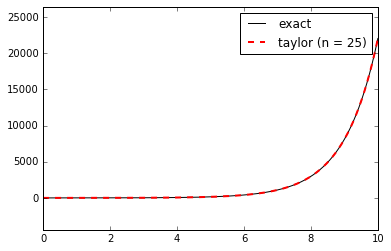

In [51]:
# Taylor series
def f(x):
    """Return real number f(x) given real number x."""
    return np.exp(x)
    #return np.sin(x)
def df(x, n):
    """Return a real number giving the n^th derivative of f at point x"""
    return np.exp(x)
    # since d^n sin(x) = d^n Imag{ exp(i x) } = Imag{ i^n exp( i x) } = Imag { exp (i (x + n pi/2))}
    #return np.sin(x + n * np.pi / 2)

def taylor(x, nmax=1, f=f, df=df, x0=0.0):
    """Evaluate Taylor series for input array 'x', up to order 'nmax', around 'x0'.
    """
    y = f(x0)
    n_factorial = 1.0
    for n in range(1, nmax + 1):
        n_factorial *= n
        y +=  (x - x0)**n * df(x0, n) / n_factorial
    return y

x = np.linspace(0, 10, 1000)
yexact = f(x)
def approx(n=25):
    plt.plot(x, yexact, 'k', lw=1, label='exact')
    plt.plot(x, taylor(x, n), '--r', lw=2, label='taylor (n = %d)' % n)
    plt.legend(loc=0)
    yrange = yexact.max() - yexact.min()
    plt.ylim([yexact.min() - 0.2 * yrange, yexact.max() + 0.2 * yrange])
if LECTURE:
    i = interact(approx, interact(n=(1, 50)))
else:
    approx()
plt.savefig('fig03-01.pdf')




## Note

We can choose bigger and bigger values for $h$. This is in fact how computers calculate transcendental functions like $\exp$, $\sin$ or $\cos$. For example, using $t_i = 0$ in the above equation,

\begin{align}
y(t) &= \exp(t), & &\Rightarrow& y^{(n)}(t_i) &= \exp(t_i), & &\Rightarrow& \exp(h) &\approx \sum_{j = 0}^n \frac{h^j}{j!} \\
y(t) &= \sin(t), & &\Rightarrow& y^{(n)}(t_i) &= \sin \left(t_i + n \frac{\pi}{2} \right), & &\Rightarrow& \sin(h) &\approx \sum_{j = 0}^n \sin \left(j \frac{\pi}{2}\right) \frac{h^j}{j!} = \sum_{\substack{j=1 \\ j \text{ odd}}}^n (-1)^{\frac{j - 1}{2}} \frac{h^j}{j!}
\end{align}

## Limitations of Taylor's approximation

For an initial value problem, what we have is a function $F$ such that that for all $t$,

\begin{equation}
y'(t) = F(t, y(t)).
\end{equation}

We therefore have a lot of information about the first derivative, but none about higher order derivatives. We could try estimating higher order derivatives numerically but this is error prone. We need an alternative approach.

# Runge-Kutta methods

## Rationale

One popular solution to the limitations of Taylor's approximation is to use a Runge-Kutta method. A Runge-Kutta method of order $n$ produces an estimate $y'_e$ for the effective slope of the solution $y(t)$ over the interval $[t_i, t_i + h]$, so that the following expression approximates $y(t_i + h)$ to order $n$:

\begin{equation}
y(t_i + h) \approx y(t_i) + h y'_e
\end{equation}



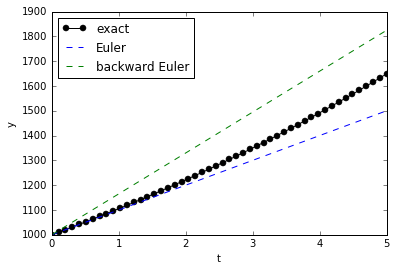

In [4]:
AVERAGE = False
t = np.linspace(0, 5)
h = 5
y0 = 1000
r = 0.1
yexact = y0 * np.exp(r * t)

def F(y):
    return 0.1 * y
F0 = F(yexact[0])
F1 = F(yexact[-1])
y_feuler = y0 + t * F0
y_beuler = y0 + t * F1

plt.figure(2)
plt.clf()
plt.plot(t, yexact, 'k-o', label='exact')
plt.plot(t, y_feuler, '--', label='Euler')
plt.plot(t, y_beuler, '--', label='backward Euler')
if AVERAGE:
    effective_slope = (F0 + F1) / 2
    y_av = y0 + t * effective_slope
    plt.plot(t, y_av, '--', label='effective slope?')
plt.legend(loc=0)
plt.xlabel('t')
plt.ylabel('y')
plt.savefig('fig03-02.pdf')



In Runge-Kutta methods, the effective slope $y'_e$ is obtained:
1.  by estimating the slope $y'(t) = F(t, y)$ at different intermediate times within $[t_i, t_i + h]$.
2.  by applying a weighted average to these slopes.

Thus a $q$ stage Runge-Kutta method defines
-   a set of $q$ intermediate times (&tau;<sub>j</sub>) such that $t_i \leq \tau_1 \leq \tau_2 \leq \cdots \leq \tau_q \leq t_i + h$.
-   a set of $q$ estimates for the slopes $k_1=y'(\tau_1), k_2=y'(\tau_2), \cdots, k_q=y'(\tau_q)$
-   a set of weights $c_1$, $c_2, \cdots c_q$ that define the weighted average giving the effective slope $y'_e$:

\begin{equation}
y'_e = c_1 k_1 + c_2 k_2 + \cdots + c_q k_q.
\end{equation}

Combining the two equations above yields

\begin{equation}
y_{i+1} = y_i + h(c_1 k_1 + c_2 k_2 + \cdots + c_q k_q).
\end{equation}

The rationale behind Runge-Kutta methods is to define the weighting coefficients $c_1, c_2, \cdot, c_q$ so that the above expression matches Taylor's approximation for $y_{i+1} = y(t_i + h)$ to the desired order of accuracy. This is always possible to use a sufficient number of intermediate steps. We need $q \geq n$ stages to obtain a Runge-Kutta method accurate of order $n$.

## Example I: mid-point rule (RK2)

For example, the mid-point rule is a stage 2 Runge-Kutta method such that:

\begin{align}
\tau_1 &= t_i, & \tau_2 &= t_i + h = t_{i+1} \\
c_1 &= \frac{1}{2}  & c_2 &= \frac{1}{2},
\end{align}


so

\begin{align}
y_{i+1} &= y_i + \frac{h}{2}(k_1 + k_2), \\
k_1 &= F(t_i, y_i),  \\
k_2 &= F(t_i + h, y_i + h k_1).
\end{align}

The weights $c_1$ and $c_2$ are such that the mid-point rule is accurate to order 2. This can proven by expanding $y_{i+1} = y(t_i + h)$ and $k_2$ using Taylor's approximation to order 2; matching the coefficients of order 1 and 2 yields two equations with two unknowns $c_1$ and $c_2$ whose solution is $c_1 = c_2 = 1/2$. The derivation is given in Appendix A.

### Implementation



In [7]:
def rk2(F, a, b, ya, n):
    """Solve the first order initial value problem
         y'(t) = F(t, y(t)), y(a) = ya,
    using the mid-point Runge-Kutta method and return (tarr, yarr),
    where tarr is the time grid (n uniformly spaced samples between a
    and b) and yarr the solution

    Parameters
    ----------
    F : function
         A function of two variables of the form F(t, y), such that
         y'(t) = F(t, y(t)).
    a : float
         Initial time.
    b : float
         Final time.
    n : integer
         Controls the step size of the time grid, h = (b - a) / (n - 1)
    ya : float
         Initial condition at ya = y(a).
    """
    tarr = np.linspace(a, b, n)
    h = tarr[1] - tarr[0]
    ylst = []
    yi = ya
    for t in tarr:
        ylst.append(yi)
        k1 = F(t, yi)
        k2 = F(t + h / 2.0, yi + h * k1)
        yi += 0.5 * h * (k1 + k2)
    yarr = np.array(ylst)
    return tarr, yarr



### Results



In [8]:
def interest(ode_solver, n, r=0.1, y0=1000, t0=0.0, t1=5.0):
    """Solve ODE   y'(t) = r y(t), y(0) = y0 and return the absolute error.

    ode_solver : function
         A function ode_solver(F, a, b, ya, n) that solves an explicit
         initial value problem y'(t) = F(t, y(t)) with initla
         condition y(a) = ya. See 'euler', or 'rk2'.
    n : integer, optional
         The number of time steps
    r : float, optional
         The interest rate
    y0 : float, optional
         The amount of savings at the initial time t0.
    t0 : float, optional
         Initial time.
    t1 : float, optional
         Final time.
    """
    # Exact solution
    t = np.linspace(t0, t1)
    y = y0 * np.exp(r * t)
    y1 = y[-1]
    print ("Savings after %d years = %f" %(t1, y1))
    # Plot the exact solution if the figure is empty
    if not plt.gcf().axes:
        plt.plot(t, y, 'o-k', label='exact', lw=4)
        plt.xlabel('Time [years]')
        plt.ylabel(u'Savings [£]')
    # Numerical solution
    F = lambda t, y: r * y  # the function y'(t) = F(t,y)
    tarr, yarr = ode_solver(F, t0, t1, y0, n)
    yarr1 = yarr[-1]
    abs_err = abs(yarr1 - y1)
    rel_err = abs_err / y1
    print ("%s steps: estimated savings = %8.6f,"\
          " error = %8.6f (%5.6f %%)" % (str(n).rjust(10), yarr1,
                                         abs_err, 100 * rel_err))
    plt.plot(tarr, yarr, label='n = %d' % n, lw=2)
    plt.legend(loc=0)
    return tarr, yarr, abs_err



Compute and plot the solution:



Savings after 5 years = 1648.721271
         2 steps: estimated savings = 1625.000000, error = 23.721271 (1.438768 %)
Savings after 5 years = 1648.721271
         4 steps: estimated savings = 1645.353759, error = 3.367511 (0.204250 %)
Savings after 5 years = 1648.721271
         8 steps: estimated savings = 1648.056899, error = 0.664371 (0.040296 %)
Savings after 5 years = 1648.721271
        16 steps: estimated savings = 1648.572384, error = 0.148887 (0.009030 %)
Savings after 5 years = 1648.721271
        32 steps: estimated savings = 1648.685958, error = 0.035312 (0.002142 %)
Savings after 5 years = 1648.721271
        64 steps: estimated savings = 1648.712668, error = 0.008603 (0.000522 %)
Savings after 5 years = 1648.721271
       128 steps: estimated savings = 1648.719147, error = 0.002123 (0.000129 %)


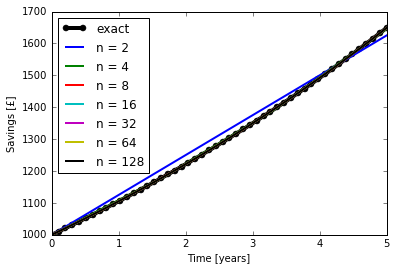

In [9]:
nbsteps = [2, 4, 8, 16, 32, 64, 128]
errlst = []
plt.figure(3)
plt.clf()
for n in nbsteps:
    tarr, yarr, abs_err = interest(rk2, n)
    errlst.append(abs_err)
plt.savefig('fig03-03.pdf')



Plot the absolute error:



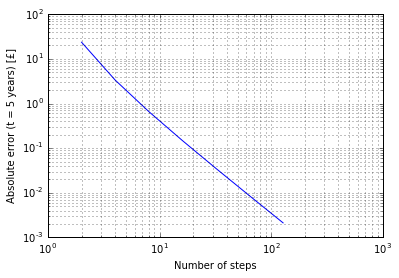

In [10]:
plt.figure(4)
plt.clf()
plt.loglog(nbsteps, errlst)
plt.xlabel('Number of steps')
plt.ylabel(u'Absolute error (t = %d years) [£]' % tarr[-1])
plt.grid(which='both')
plt.savefig('fig03-04.pdf')




## Example II: The Runge-Kutta method (RK4)

The classical Runge-Kutta method, or simply *the* Runge-Kutta method, is given by

\begin{align}
\tau_1 &= t_i, & \tau_2 &= t_i + \frac{h}{2},&  \tau_3 &= t_i + \frac{h}{2}, & \tau_4 &= t_i + h = t_{i+1} \\
c_1 &= 1/6, & c_2 &= 1/3,&  c_3 &= 1/3, & c_4 &= 1/6 \\
\end{align}

\begin{align}
y_{i+1} &= y_i + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4).
\end{align}

where

\begin{align}
k_1 &= F(t_i, y_i),  &
k_2 &= F(t_i + \frac{h}{2}, y_i + \frac{h}{2} k_1), \\
k_3 &= F(t_i + \frac{h}{2}, y_i + \frac{h}{2} k_2), &
k_4 &= F(t_i + h, y_i + h k_3).
\end{align}

The weights are such that RK4 is accurate to order 4. The weights can be obtained by following the same derivation as that presented in Appendix A for RK2. Thus, expanding $y_{i+1} = y(t_i + h)$, $k_2$, $k_3$ and $k_4$ using Taylor's approximation to order 4, and matching the coefficients of orders 1 to 4 yields four equations with four unknowns $c_1, c_2, c_3$ and $c_4$ whose solution is $c_1=c_4=1/6$ and $c_2=c_3=1/3$. The derivation is left as an exercise to the reader. The derivation is given in [​1] or [2, 3].



In [11]:
def rk4(F, a, b, ya, n):
    """Solve the first order initial value problem
         y'(t) = F(t, y(t)),
          y(a) = ya,
    using the Runge-Kutta method and return a tuple made of two arrays
    (tarr, yarr) where 'ya' approximates the solution on a uniformly
    spaced grid 'tarr' over [a, b] with n elements.

    Parameters
    ----------
    F : function
         A function of two variables of the form F(t, y), such that
         y'(t) = F(t, y(t)).
    a : float
         Initial time.
    b : float
         Final time.
    n : integer
         Controls the step size of the time grid, h = (b - a) / (n - 1)
    ya : float
         Initial condition at ya = y(a).
    """
    tarr = np.linspace(a, b, n)
    h = tarr[1] - tarr[0]
    ylst = []
    yi = ya
    for t in tarr:
        ylst.append(yi)
        k1 = F(t, yi)
        k2 = F(t + 0.5 * h, yi + 0.5 * h * k1)
        k3 = F(t + 0.5 * h, yi + 0.5 * h * k2)
        k4 = F(t + h, yi + h * k3)
        yi +=  h / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    yarr = np.array(ylst)
    return tarr, yarr



Compute and plot the solution using RK4:



Savings after 5 years = 1648.721271
         2 steps: estimated savings = 1648.437500, error = 0.283771 (0.017212 %)
Savings after 5 years = 1648.721271
         4 steps: estimated savings = 1648.716656, error = 0.004615 (0.000280 %)
Savings after 5 years = 1648.721271
         8 steps: estimated savings = 1648.721102, error = 0.000168 (0.000010 %)
Savings after 5 years = 1648.721271
        16 steps: estimated savings = 1648.721262, error = 0.000008 (0.000001 %)
Savings after 5 years = 1648.721271
        32 steps: estimated savings = 1648.721270, error = 0.000000 (0.000000 %)
Savings after 5 years = 1648.721271
        64 steps: estimated savings = 1648.721271, error = 0.000000 (0.000000 %)
Savings after 5 years = 1648.721271
       128 steps: estimated savings = 1648.721271, error = 0.000000 (0.000000 %)


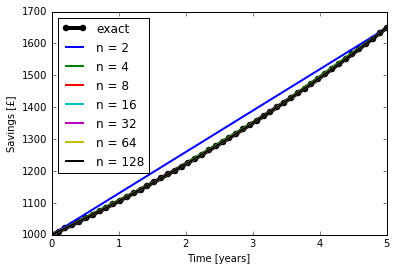

In [12]:
#nbsteps = [10, 100, 1000, 10000]
errlst = []
plt.figure(5)
plt.clf()
for n in nbsteps:
    tarr, yarr, abs_err = interest(rk4, n)
    errlst.append(abs_err)
plt.savefig('fig03-05.pdf')



Plot the absolute error using RK4:



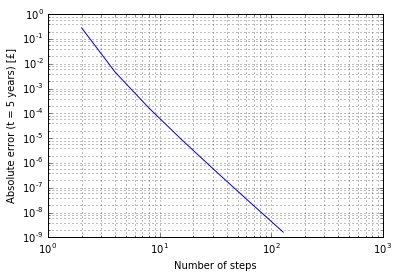

In [13]:
plt.figure(6)
plt.clf()
plt.loglog(nbsteps, errlst)
plt.xlabel('Number of steps')
plt.ylabel(u'Absolute error (t = %d years) [£]' % tarr[-1])
plt.grid(which='both')
plt.savefig('fig03-06.pdf')



## Efficiency of Runge-Kutta methods

Accurate results can be obtained by:
1.  decreasing the time step $h$;
2.  using a higher order method.

Higher order methods are more accurate but also more expansive, because they do more work during each time step. The amount of work being done may become prohibitive, so that it may be more efficient to use a lower order method with a smaller time step.  There is therefore a trade-off between accuracy and computational cost. For Runge-Kutta methods, the peak efficiency is

# Stability and stiffness

Instead of approaching the exact solution $y(t)$ to a particular ODE, the numerical solution may diverge from it. This is due to stability issues. Stability depends on 3 factors:
-   the differential equation.
-   the method of solution.
-   the step size.

Some differential equations are particularly challenging to solve numerically. These are usually vector ODEs in which some components vary much more rapidly than other components [​4]. The step size is then constrained by the component that varies most rapidly. See Exercise 2 in the Self Study section for an example of stiffness and stability issues.

Before applying a particular method such as RK4 to solve an ODE, you should investigate the stiffness of the ODE and the stability of your problem, otherwise you may get an incorrect solution.

# Beyond Runge-Kutta

-   *Adaptive methods* allow us to take big steps when the function is smooth, but tiptoe more carefully when the function is varying more. A typical scheme might try a step size of $h$ and then $2h$ and adapt accordingly.
-   More sophisticated methods e.g. *Runge-Kutta-Fehlberg* (RKF45) is a further refinement of the method which also use a 4<sup>th</sup> order and 5<sup>th</sup> order approximation which enable the truncation error to be estimated and the step size to be adapted accordingly.
-   The *Bulirsch-Stoer* Algorithm takes this one step further (no pun intended) and carefully extrapolates to what would happen if the step size was zero and judicious choice of approximation of the function to produce what is generally considered to be a very good way to solve a wide class of ordinary differential equation problems.
-   Buyer beware that methods can get stuck if the function has discontinuities in the range&#x2026;

# Conclusions

-   Given and ODE $y'(t) = F(t, y(t))$ with $y(t_i) = y_i$, Runge-Kutta methods estimate the derivative at intermediate times using $y_i$ and $F(t, y(t)$ between $t_i$ and $t_i + h$, and use a weighted average of these estimates to approximate $y_{i+1}$.
-   You should be able to write an implementation of RK4 based on

\begin{align}
\tau_1 &= t_i, & \tau_2 &= t_i + \frac{h}{2},&  \tau_3 &= t_i + \frac{h}{2}, & \tau_4 &= t_i + h = t_{i+1} \\
c_1 &= 1/6, & c_2 &= 1/3,&  c_3 &= 1/3, & c_4 &= 1/6 \\
\end{align}

\begin{align}
y_{i+1} &= y_i + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4).
\end{align}where

\begin{align}
k_1 &= F(t_i, y_i),  &
k_2 &= F(t_i + \frac{h}{2}, y_i + \frac{h}{2} k_1), \\
k_3 &= F(t_i + \frac{h}{2}, y_i + \frac{h}{2} k_2), &
k_4 &= F(t_i + h, y_i + h k_3).
\end{align}

-   You should be able to solve an initial value problem using RK4 or similar methods.
-   There is a trade-off between the order of the method and the computational cost. Higher order methods are more accurate but more costly, so it may be more efficient to use a lower order method with a smaller step size.

# Self study

-   Describe in your own words the rationale behind Runge-Kutta methods.
-   Use Euler and RK4 to solve the following ODE between 0 and 1

\begin{align}
y'(t) &= -15 y(t) \\
y(0) &= 1
\end{align}

What happens when you use a time step $h$ larger than 0.25?
-   Use RK4 to solve the following inital value problem between 0 and $2\pi$

\begin{align}
y'(t) &= \cos(y(t)) \\
y(0) &= 0
\end{align}

Compare your result with the exact solution $y(t) = \sin(t)$
-   Implement RK6, defined in Appendix B, and solve the ODE in example 1 using it. Compare the time needed to reach a desired level of accuracy using RK6 compared to RK4. Which is more efficient?

The rationale behind RK methods is that intermediate points are computed in the time interval. The difference from using a smaller step size is that the intermediate points are weighted differently when computing the next time step of interest.

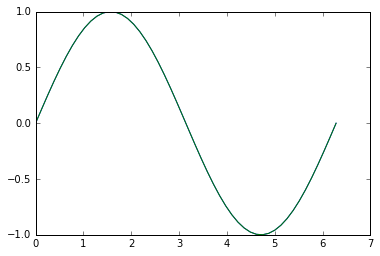

In [18]:
F1 = lambda y, t: -15*y
F2 = lambda y, t: np.cos(y)
tarr, y1 = rk4(F1, 0, 1, 1, 50)
tarr, y2 = rk4(F2, 0, 2*np.pi, 0, 50)
plt.plot(tarr, y2)
plt.plot(tarr, np.sin(tarr))

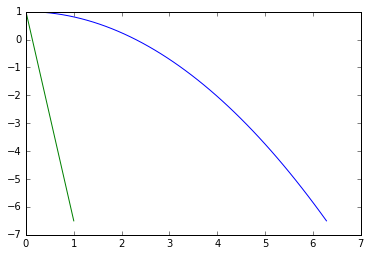

In [19]:
plt.plot(tarr, y1)
tarr, y1 = rk4(F1, 0, 1, 1, 2)
plt.plot(tarr, y1)

In [21]:
def rk6(F, a, b, ya, n):
    """Solve the first order initial value problem
         y'(t) = F(t, y(t)),
          y(a) = ya,
    using the Runge-Kutta method and return a tuple made of two arrays
    (tarr, yarr) where 'ya' approximates the solution on a uniformly
    spaced grid 'tarr' over [a, b] with n elements.

    Parameters
    ----------
    F : function
         A function of two variables of the form F(t, y), such that
         y'(t) = F(t, y(t)).
    a : float
         Initial time.
    b : float
         Final time.
    n : integer
         Controls the step size of the time grid, h = (b - a) / (n - 1)
    ya : float
         Initial condition at ya = y(a).
    """
    tarr = np.linspace(a, b, n)
    h = tarr[1] - tarr[0]
    ylst = []
    yi = ya
    for t in tarr:
        ylst.append(yi)
        k1 = F(t, yi)
        k2 = F(t + 0.5 * h, yi + 0.5 * h * k1)
        k3 = F(t + 0.5 * h, yi + 0.5 * h * k2)
        k4 = F(t + 0.5 * h, yi + 0.5 * h * k3)
        k5 = F(t + 0.5 * h, yi + 0.5 * h * k4)
        k6 = F(t + h, yi + h * k5)
        yi +=  h * (k1/45.0 + k2/3.0 + k3/3.0 + k4/5.0 + k5/15.0 + k6/45.0)
    yarr = np.array(ylst)
    return tarr, yarr



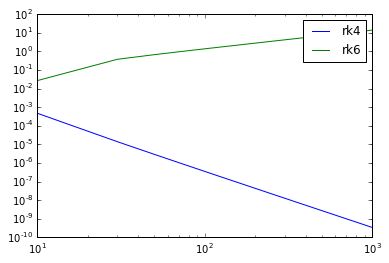

In [49]:
#Wrong
err1=[]
err2=[]
for n in np.arange(10, 1000, 20):
    tarr, y_rk4 = rk4(F2, 0, 2*np.pi, 0, n)
    tarr, y_rk6 = rk6(F2, 0, 2*np.pi, 0, n)
    err1.append(np.sum(np.abs(y_rk4 - np.sin(tarr))))
    err2.append(np.sum(np.abs(y_rk6 - np.sin(tarr))))
plt.loglog(np.arange(10, 1000, 20), err1, label="rk4")
plt.loglog(np.arange(10, 1000, 20), err2, label="rk6")
plt.legend()

# References

1.  Lyu, Ling-Hsiao (2013), *Numerical Simulation of Space Plasmas (I)* [AP-4036], Appendix C.2.3 [{pdf}](http://www.ss.ncu.edu.tw/~lyu/lecture_files_en/lyu_NSSP_Notes/Lyu_NSSP_AppendixC.pdf())
2.  Mathews, J.H. and Fink, K.D. “Numerical methods using Matlab: 3rd edition” Prentice-Hall. ISBN 0132700425. There is a 4th edition of this available (ISBN-13: 978-0130652485)
3.  Stoer J and Bulirsch R (2010) “Introduction to Numerical Analysis” Springer. ISBN 144193006X

# Appendix A: derivation of the mid-point rule (RK2)

In the mid-point rule, the two intermediate times are $\tau_1 = t_i$ and $\tau_2 = t_i + h/2$. We seek the weighting coefficients $c_1$ and $c_2$ such that the following Runge-Kutta approximation is accurate to order 2

\begin{align}
y(t_i + h) &= y_i + h(c_1 k_1 + c_2 k_2), &
k_1 &= F(t_i, y_i),  & k_2 &= F(t_i + h, y_i + h k_1).
\end{align}

Expanding the slope estimate $k_2$ using Taylor's theorem, we have
For example

\begin{align}
k_2 &= F(t_i + h, y_i + h k_1) \equiv K_2(h) \\
    &\approx K_2(0) + h K_2'(0) \\
    &\approx F(t_i, y_i) + h F'(t_i, y_i) \equiv F_i + h F_i',
\end{align}

where we have introduced the function $K_2(h) = F(t_i + h, y_i + k_1 h)$ and where $F'$ denotes the derivative of $t \mapsto F(t, y(t))$. Substituting the results into our Runge-Kutta equation, and using $k_1 = F_i$,  yields

\begin{align}
y(t_i + h) &\approx y_i + h (c_1 + c_2) F_i + h^2 c_2 F_i'.
\end{align}

If we also expand the left hand side $y(t_i + h)$ using Taylor's expansion to order 2, we get

\begin{equation}
y_i + h F_i + \frac{h^2}{2} F_i' \approx y_i + h (c_1 + c_2) F_i + h^2 c_2 F_i'.
\end{equation}

Equating the coefficients of $h$ and $h^2$ yields

\begin{equation}
\left\{
\begin{aligned}
c_1 + c_2 &= 1 \\
c_2 = \frac{1}{2}
\end{aligned}
\right.
\end{equation}

so $c_1 = c_2 = 1/2$, which gives the mid-point rule

\begin{align}
y_{i+1} &= y_i + \frac{h}{2} (F(t_i, y_i) +  F(t_i + \frac{h}{2}, y_i + \frac{h}{2}k_1).
\end{align}

# Appendix B: Higher order Runge-Kutta methods

Reference [​1] presents similar derivations for Runge-Kutta methods of order 3,4, 5 and 6, assuming intermediate points such that

\begin{align}
\tau_1 &= t_i, &
\tau_q &= t_{i+1}, &
\tau_j &= \frac{t_i + t_{i+1}}{2} \quad \text{for all} \quad $1 < j < q$
\end{align}

The weights are given below:
-   Order 3

\begin{align}
c_1 &= \frac{2}{3!} = \frac{1}{3}, & c_2 &= \frac{1}{3},& c_3 &= \frac{2}{3!} = \frac{1}{3}
\end{align}

-   Order 4

\begin{align}
c_1 &= \frac{2^2}{4!} = \frac{1}{6}, & c_2 &= \frac{1}{3},&  c_3 &= \frac{1}{3}, & c_4 &= \frac{2^2}{4!} = \frac{1}{6}
\end{align}

-   Order 5

\begin{align}
c_1 &= \frac{2^3}{5!} = \frac{1}{15}, & c_2 &= \frac{1}{3},&  c_3 &= \frac{1}{3}, & c_4 &= \frac{1}{5}, & c_5 &= \frac{2^2}{4!} = \frac{1}{15}
\end{align}

-   Order 6

\begin{align}
c_1 &= \frac{2^4}{6!} = \frac{1}{45}, & c_2 &= \frac{1}{3},&  c_3 &= \frac{1}{3}, & c_4 &= \frac{1}{5}, & c_5 &= \frac{4}{15}, & c_6 = \frac{2^4}{6!} = \frac{1}{45}
\end{align}

Note that the coefficients
-   tend to be symmetrical
-   $c_1 = c_q = 2^{q-2} / q!$
-   $c_1 + c_2 + \cdots + c_q = 1$.
-   Most of the interior coefficients $c_j,1 < j < q$ for the order $q$ Runge-Kutta scheme are identical to those from the stage $q-1$ Runge-Kutta scheme.